# Package

In [6]:
import time
import os
from copy import deepcopy 

import tensorflow as tf
from tensorflow.contrib import rnn

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle, resample
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

Package is ready.


In [7]:
matplotlib.rcParams['figure.figsize'] = (20, 15)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293", "#6bbcb3"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442", "#1ca597"]

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

# Hyperparameters

In [8]:
N_FOLD = 5
EX_PRED = 10000

# Data Preparation

## loading

In [9]:
# Load data
l = np.load("./data/Allenv_MT-LN-LSTM_T144_I10 min.npz")

# See what's in here
print (l.files)

# get data
rnn_input = l["inputs"]
rnn_label = l["labels"]

MINS = l["mins"]
MAXS = l["maxs"]

LABELMINS = l["labelmins"]
LABELMAXS = l["labelmaxs"]

TIME_STEPS = int(l["timesteps"])
OUTPUT_SIZE = int(l["outputsize"])

START_OUTPUT = pd.DatetimeIndex(l["start_output"])
START_INPUT = pd.DatetimeIndex(l["start_input"])
END_OUTPUT = pd.DatetimeIndex(l["end_output"])
END_INPUT = pd.DatetimeIndex(l["end_input"])
INTERVAL = pd.Timedelta(str(l["interval"]))

#EXPLANATION = str(l["explanation"])
EXPLANATION = "Allenv_MT-LN-LSTM" + "_T" + str(TIME_STEPS) + "_I" + str(l["interval"])

['labelmins', 'interval', 'maxs', 'start_output', 'start_input', 'labelmaxs', 'labels', 'outputsize', 'explanation', 'end_input', 'end_output', 'inputs', 'mins', 'timesteps']


In [10]:
EXPLANATION

'Allenv_MT-LN-LSTM_T144_I10 min'

In [11]:
N_TASKS = 6

## Separating

In [12]:
print("time steps: %d, " % TIME_STEPS, end="")
print("output size: %d" % OUTPUT_SIZE)
print("Number of data: %d" % len(rnn_label))
print("Number of input: %d" % rnn_input[0].shape[1])

time steps: 144, output size: 12
Number of data: 87252
Number of input: 15


In [7]:
N_DATA = len(rnn_label)
RATIO = 0.3
N_TEST = int(np.trunc(N_DATA*RATIO))
FOLD_INTERVAL = int(np.trunc((N_DATA - N_TEST)/(N_FOLD - 1)))

print("%d-fold validation setting" % N_FOLD)
print("Test ratio: %.2f\nNumber of test: %d\nFolding interval: %d" % (RATIO, N_TEST, FOLD_INTERVAL))

5-fold validation setting
Test ratio: 0.30
Number of test: 26175
Folding interval: 15269


In [8]:
pred_indexs = []
    
for i in range(N_FOLD):
    pred_indexs.append(FOLD_INTERVAL*i)

In [9]:
pred_inputs = []
pred_labels = []
rnn_inputs = []
rnn_labels = []

pred_input_index = []
pred_label_index = []

i = 0

for pred_index in pred_indexs[:-1]:
    pred_input = rnn_input[pred_index:pred_index+N_TEST, :, :]
    pred_input_index.append(START_INPUT[pred_index:pred_index+N_TEST])
    
    pred_label = rnn_label[pred_index:pred_index+N_TEST, :]
    pred_label_index.append(START_OUTPUT[pred_index:pred_index+N_TEST])
    
    pred_inputs.append(pred_input)
    pred_labels.append(pred_label)

    rnn_inputs.append(rnn_input)
    rnn_labels.append(rnn_label)
    rnn_inputs[i] = np.delete(rnn_inputs[i], [i for i in range(pred_index, pred_index+N_TEST+OUTPUT_SIZE)], axis=0)
    rnn_labels[i] = np.delete(rnn_labels[i], [i for i in range(pred_index, pred_index+N_TEST+OUTPUT_SIZE)], axis=0)
    i += 1

pred_index = pred_indexs[-1]
pred_input = rnn_input[pred_index:pred_index+N_TEST, :, :]
pred_input_index.append(START_INPUT[pred_index:pred_index+N_TEST])

pred_label = rnn_label[pred_index:pred_index+N_TEST, :]
pred_label_index.append(START_OUTPUT[pred_index:pred_index+N_TEST])

pred_inputs.append(pred_input)
pred_labels.append(pred_label)

rnn_inputs.append(rnn_input)
rnn_labels.append(rnn_label)
rnn_inputs[-1] = rnn_inputs[-1][:pred_index]
rnn_labels[-1] = rnn_labels[-1][:pred_index]

In [10]:
for i in range(N_FOLD):
    rnn_inputs[i], rnn_labels[i] = shuffle(rnn_inputs[i], rnn_labels[i])

In [11]:
pred_inputs[0].shape

(26175, 144, 15)

In [12]:
pred_labels[0].shape

(26175, 12, 6)

In [13]:
print("Data is ready.")

Data is ready.


# Training & Plotting

In [14]:
def FC(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, activation_fn=None, scope=scope)

def BN_FC(x, n_hidden, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=None, scope='FC')
        h2 = tf.layers.batch_normalization(h1, training=phase)
        return tf.nn.relu(h2, 'relu')

In [15]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

1-fold started.
Epoch:        0/   50000 cost: 6.840350, best: 100000.000
Training Acc: -33.767, Test Acc: -20.126
-56.855 -34.816 -245.460 -164.877 -50.930 -141.370 
-115.71802625752088
Epoch:      500/   50000 cost: 0.028398, best: 100000.000
Training Acc: 0.457, Test Acc: 0.521
-0.176 -4.943 -0.080 0.466 0.327 -2.550 
-1.159337848657541
Epoch:     1000/   50000 cost: 0.018844, best: 100000.000
Training Acc: 0.757, Test Acc: 0.702
0.485 -4.704 -0.107 0.451 0.724 0.813 
-0.38976076067774235
Epoch:     1002/   50000 cost: 0.018549, best: 0.117 *Best value was replaced.
0.485 -4.704 -0.107 0.451 0.724 0.813 
-0.38976076067774235
Epoch:     1003/   50000 cost: 0.018967, best: 0.105 *Best value was replaced.
0.485 -4.704 -0.107 0.451 0.724 0.813 
-0.38976076067774235
Epoch:     1004/   50000 cost: 0.023002, best: 0.096 *Best value was replaced.
0.485 -4.704 -0.107 0.451 0.724 0.813 
-0.38976076067774235
Epoch:     1058/   50000 cost: 0.018055, best: 0.092 *Best value was replaced.
0.485 -

Epoch:     6000/   50000 cost: 0.009854, best: 0.013
Training Acc: 0.965, Test Acc: 0.958
0.846 0.718 0.067 0.757 0.975 0.905 
0.7112492851228129
Epoch:     6500/   50000 cost: 0.008670, best: 0.013
Training Acc: 0.974, Test Acc: 0.955
0.787 0.525 0.482 0.782 0.980 0.939 
0.749161569167036
Epoch:     7000/   50000 cost: 0.009388, best: 0.013
Training Acc: 0.961, Test Acc: 0.918
0.714 -0.251 0.368 0.784 0.965 0.878 
0.5761540216877518
Epoch:     7500/   50000 cost: 0.009765, best: 0.013
Training Acc: 0.962, Test Acc: 0.943
0.677 0.402 0.566 0.752 0.980 0.900 
0.7128688106414138
Epoch:     8000/   50000 cost: 0.008535, best: 0.013
Training Acc: 0.957, Test Acc: 0.923
0.713 0.196 0.330 0.777 0.983 0.435 
0.5723712100284603
Epoch:     8500/   50000 cost: 0.007578, best: 0.013
Training Acc: 0.964, Test Acc: 0.953
0.761 0.702 0.503 0.468 0.988 0.926 
0.7245178539466184
Epoch:     9000/   50000 cost: 0.007610, best: 0.013
Training Acc: 0.959, Test Acc: 0.958
0.800 0.593 0.539 0.680 0.991 0.95

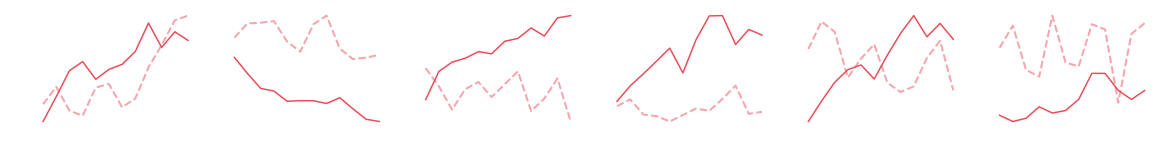

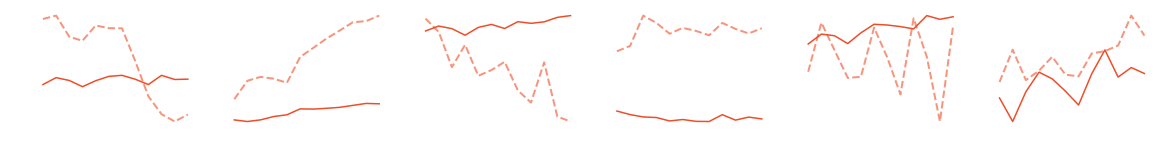

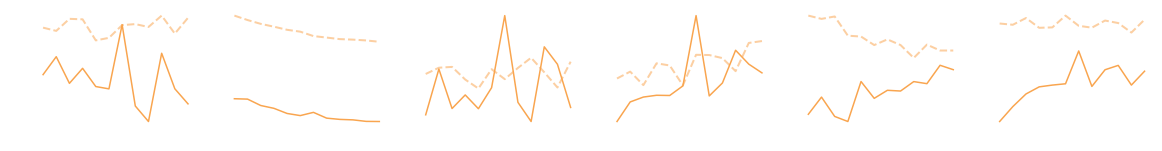

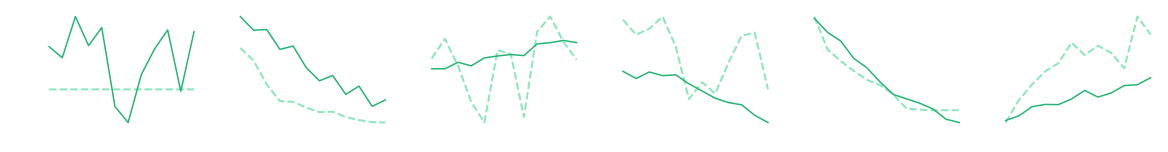

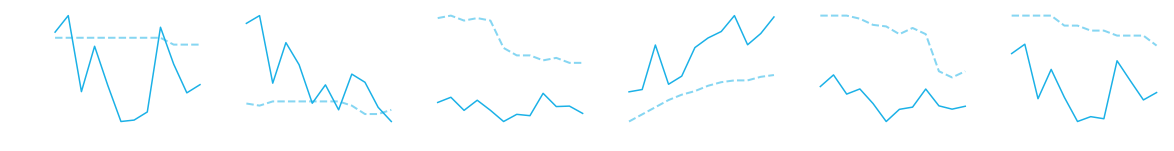

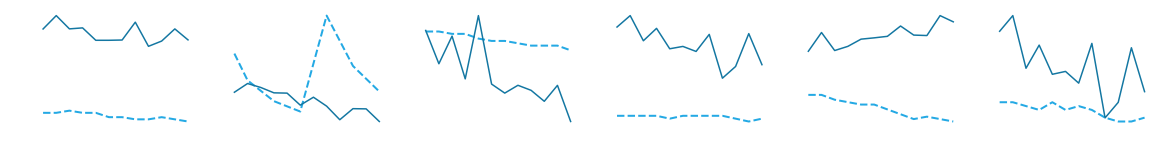

2-fold started.
Epoch:        0/   50000 cost: 7.396958, best: 100000.000
Training Acc: -112.255, Test Acc: -101.294
-132.118 -292.376 -3789.956 -292.897 -108.775 -107.793 
-787.3193005208174
Epoch:      500/   50000 cost: 0.021650, best: 100000.000
Training Acc: 0.788, Test Acc: 0.657
0.395 -0.156 0.022 0.484 0.322 0.469 
0.25601802008820607
Epoch:     1000/   50000 cost: 0.017338, best: 100000.000
Training Acc: 0.821, Test Acc: 0.794
0.894 0.727 -24.312 0.755 0.863 0.892 
-3.363602730739442
Epoch:     1002/   50000 cost: 0.015758, best: 0.083 *Best value was replaced.
0.894 0.727 -24.312 0.755 0.863 0.892 
-3.363602730739442
Epoch:     1003/   50000 cost: 0.015313, best: 0.077 *Best value was replaced.
0.894 0.727 -24.312 0.755 0.863 0.892 
-3.363602730739442
Epoch:     1004/   50000 cost: 0.015068, best: 0.069 *Best value was replaced.
0.894 0.727 -24.312 0.755 0.863 0.892 
-3.363602730739442
Epoch:     1005/   50000 cost: 0.018673, best: 0.063 *Best value was replaced.
0.894 0.727 

Epoch:     9500/   50000 cost: 0.007658, best: 0.013
Training Acc: 0.966, Test Acc: 0.964
0.927 0.874 0.695 0.840 0.996 0.924 
0.8758600349321486
Epoch:    10000/   50000 cost: 0.006343, best: 0.013
Training Acc: 0.959, Test Acc: 0.953
0.914 0.777 0.508 0.838 0.987 0.924 
0.8245017197924338
Epoch:    10500/   50000 cost: 0.005614, best: 0.013
Training Acc: 0.976, Test Acc: 0.963
0.923 0.840 0.697 0.819 0.992 0.969 
0.8733395270793672
Epoch:    11000/   50000 cost: 0.005083, best: 0.013
Training Acc: 0.968, Test Acc: 0.943
0.923 0.615 0.530 0.792 0.995 0.953 
0.8014030815137667
Epoch:    11500/   50000 cost: 0.007187, best: 0.013
Training Acc: 0.930, Test Acc: 0.925
0.814 0.601 0.540 0.765 0.964 0.945 
0.7715552027779399
Epoch:    12000/   50000 cost: 0.007108, best: 0.013
Training Acc: 0.934, Test Acc: 0.935
0.793 0.835 0.557 0.825 0.971 0.823 
0.8006118015543883
Epoch:    12500/   50000 cost: 0.005754, best: 0.013
Training Acc: 0.944, Test Acc: 0.941
0.892 0.797 0.281 0.771 0.995 0.84

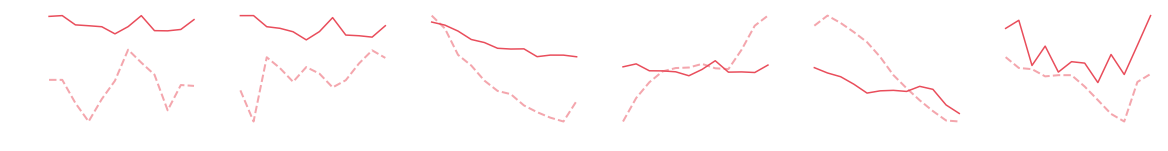

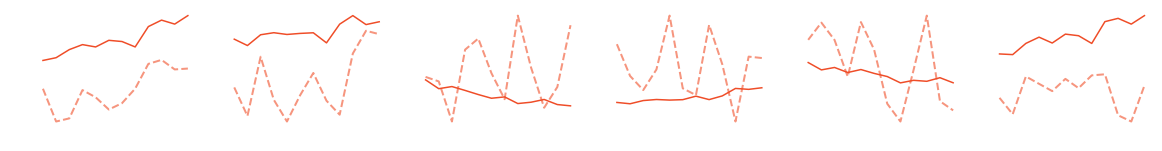

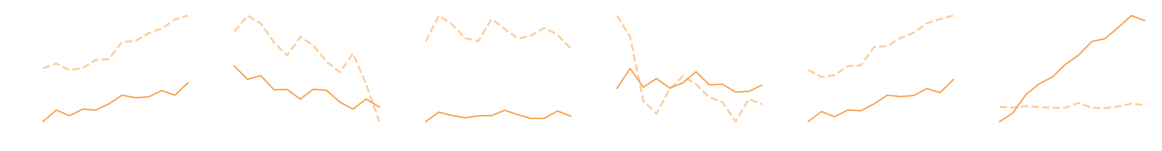

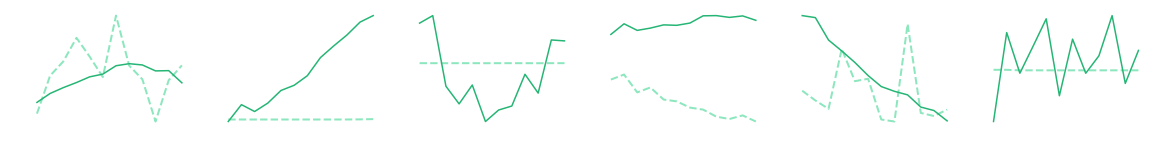

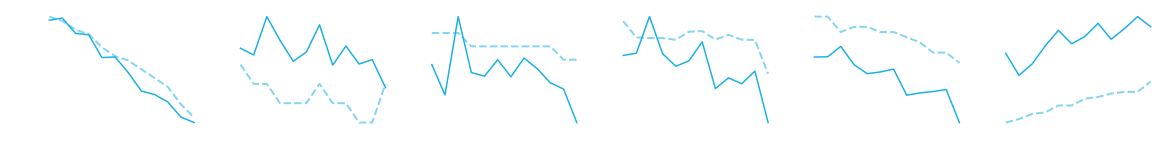

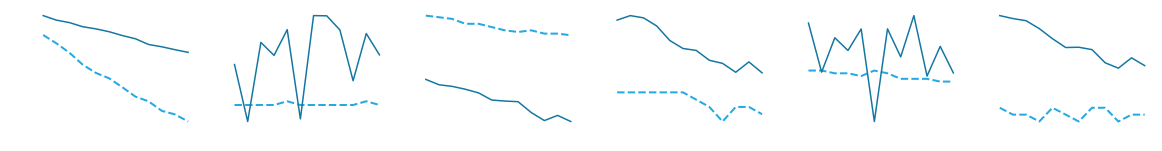

3-fold started.
Epoch:        0/   50000 cost: 7.241801, best: 100000.000
Training Acc: -331.300, Test Acc: -254.490
-2636.023 -467.324 -4560.026 -600.073 -4763.214 -456.501 
-2247.1934053700443
Epoch:      500/   50000 cost: 0.022003, best: 100000.000
Training Acc: 0.763, Test Acc: 0.877
0.171 0.599 -0.319 0.670 0.299 0.313 
0.28892221149884123
Epoch:     1000/   50000 cost: 0.013026, best: 100000.000
Training Acc: 0.910, Test Acc: 0.894
-0.219 0.636 0.139 0.608 0.397 0.737 
0.38300255380413745
Epoch:     1003/   50000 cost: 0.013270, best: 0.047 *Best value was replaced.
-0.219 0.636 0.139 0.608 0.397 0.737 
0.38300255380413745
Epoch:     1012/   50000 cost: 0.014572, best: 0.042 *Best value was replaced.
-0.219 0.636 0.139 0.608 0.397 0.737 
0.38300255380413745
Epoch:     1013/   50000 cost: 0.018910, best: 0.038 *Best value was replaced.
-0.219 0.636 0.139 0.608 0.397 0.737 
0.38300255380413745
Epoch:     1064/   50000 cost: 0.013797, best: 0.037 *Best value was replaced.
-0.219 0.

Epoch:     9500/   50000 cost: 0.005830, best: 0.018
Training Acc: 0.973, Test Acc: 0.942
0.047 0.814 0.702 0.790 0.957 0.807 
0.6860763984168275
Epoch:    10000/   50000 cost: 0.005304, best: 0.018
Training Acc: 0.974, Test Acc: 0.940
0.518 0.729 0.631 0.819 0.536 0.847 
0.6801376280741409
Epoch:    10500/   50000 cost: 0.007054, best: 0.018
Training Acc: 0.966, Test Acc: 0.929
0.068 0.783 0.573 0.602 0.936 0.891 
0.6424810976720742
Epoch:    11000/   50000 cost: 0.004962, best: 0.018
Training Acc: 0.916, Test Acc: 0.929
0.114 0.727 0.520 0.684 0.956 0.843 
0.6406256753849637
Epoch:    11500/   50000 cost: 0.005977, best: 0.018
Training Acc: 0.977, Test Acc: 0.944
0.556 0.679 0.499 0.810 0.957 0.885 
0.7309095467329101
Epoch:    12000/   50000 cost: 0.005159, best: 0.018
Training Acc: 0.948, Test Acc: 0.901
-0.333 0.663 0.667 0.437 0.938 0.890 
0.5434848645837792
Epoch:    12500/   50000 cost: 0.004581, best: 0.018
Training Acc: 0.957, Test Acc: 0.890
-0.420 0.401 0.667 0.683 0.659 0.

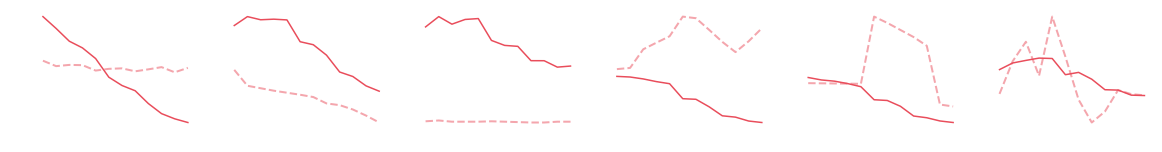

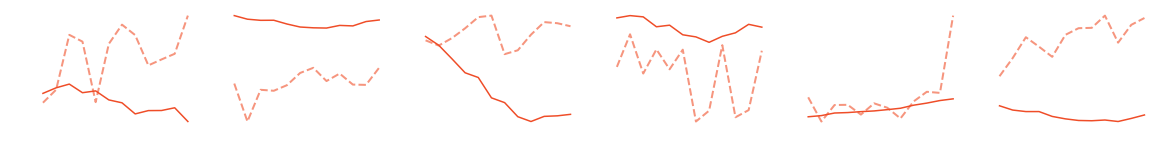

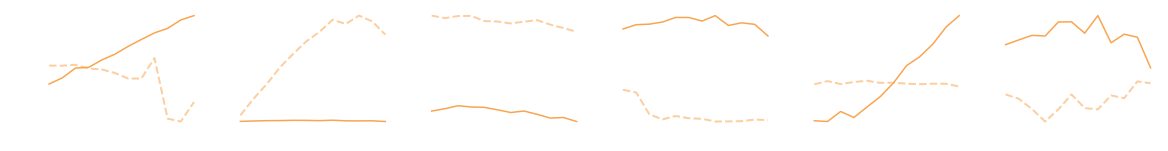

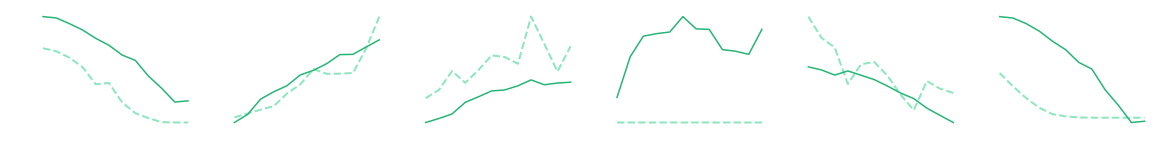

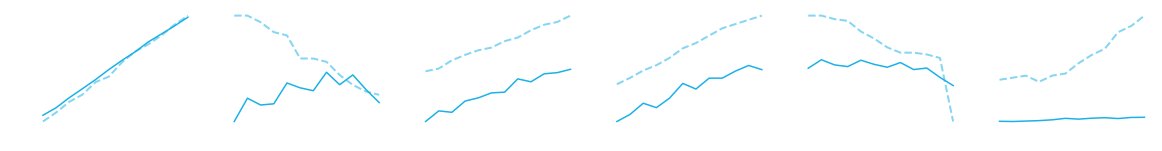

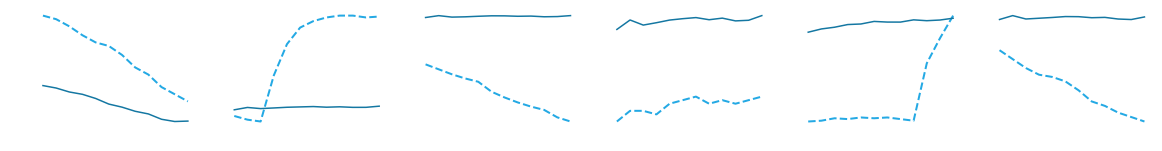

4-fold started.
Epoch:        0/   50000 cost: 7.150938, best: 100000.000
Training Acc: -46.398, Test Acc: -54.717
-393.247 -81.456 -1325.635 -268.039 -232.848 -89.603 
-398.47138661706344
Epoch:      500/   50000 cost: 0.024690, best: 100000.000
Training Acc: 0.840, Test Acc: 0.833
0.569 0.441 0.102 0.550 0.641 0.412 
0.4523761150743549
Epoch:     1000/   50000 cost: 0.019719, best: 100000.000
Training Acc: 0.728, Test Acc: 0.676
0.261 -1.021 0.070 0.639 0.794 0.344 
0.18124318541991188
Epoch:     1003/   50000 cost: 0.016815, best: 0.113 *Best value was replaced.
0.261 -1.021 0.070 0.639 0.794 0.344 
0.18124318541991188
Epoch:     1004/   50000 cost: 0.020404, best: 0.105 *Best value was replaced.
0.261 -1.021 0.070 0.639 0.794 0.344 
0.18124318541991188
Epoch:     1005/   50000 cost: 0.020371, best: 0.093 *Best value was replaced.
0.261 -1.021 0.070 0.639 0.794 0.344 
0.18124318541991188
Epoch:     1006/   50000 cost: 0.018501, best: 0.089 *Best value was replaced.
0.261 -1.021 0.07

Epoch:     5396/   50000 cost: 0.008467, best: 0.010 *Best value was replaced.
0.723 0.874 0.497 0.725 0.885 0.884 
0.7646369709633574
Epoch:     5500/   50000 cost: 0.007671, best: 0.010
Training Acc: 0.978, Test Acc: 0.962
0.493 0.885 0.548 0.776 0.992 0.972 
0.7775640392990941
Epoch:     6000/   50000 cost: 0.011625, best: 0.010
Training Acc: 0.227, Test Acc: 0.051
-21.592 0.067 -18.622 -0.060 0.453 -0.477 
-6.705078981871038
Epoch:     6500/   50000 cost: 0.010687, best: 0.010
Training Acc: 0.882, Test Acc: 0.841
0.555 0.574 -1.083 0.685 0.042 0.632 
0.23412777212378286
Epoch:     7000/   50000 cost: 0.008483, best: 0.010
Training Acc: 0.906, Test Acc: 0.871
-0.362 0.861 -0.226 0.362 0.675 0.631 
0.32341056920685013
Epoch:     7500/   50000 cost: 0.008105, best: 0.010
Training Acc: 0.947, Test Acc: 0.926
0.141 0.753 -0.106 0.679 0.846 0.972 
0.5476415950499126
Epoch:     8000/   50000 cost: 0.007947, best: 0.010
Training Acc: 0.921, Test Acc: 0.908
-0.086 0.843 0.299 0.480 0.633 0.

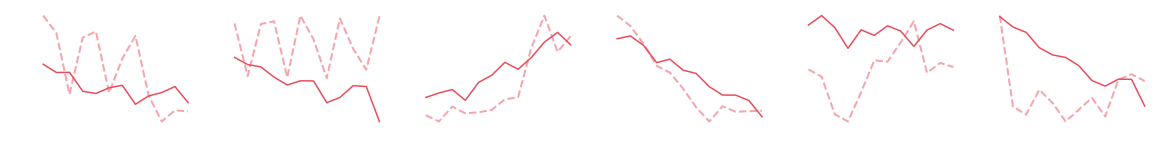

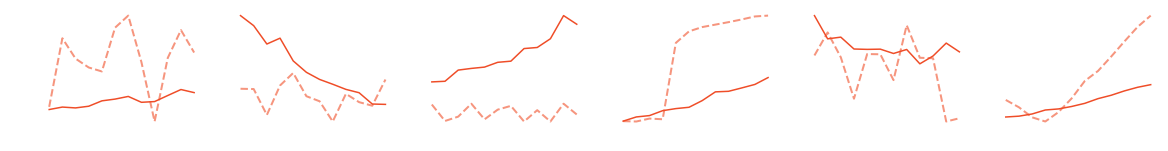

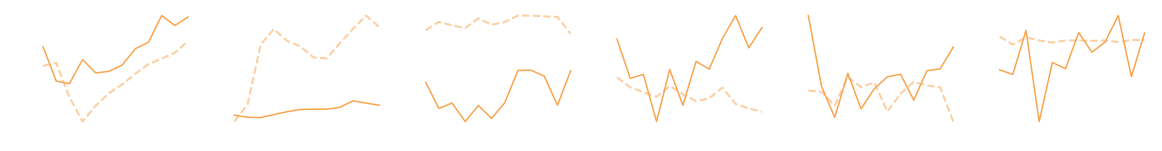

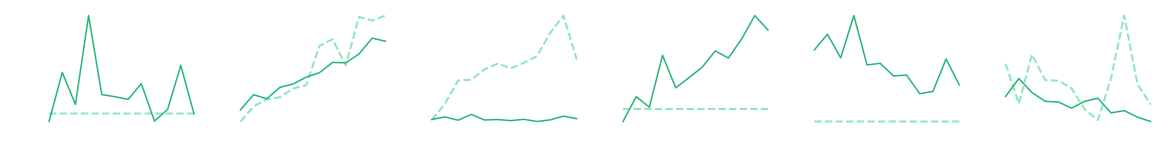

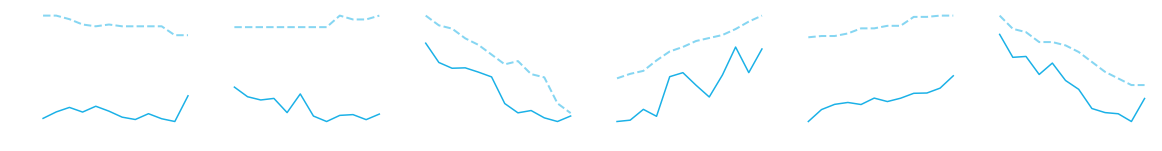

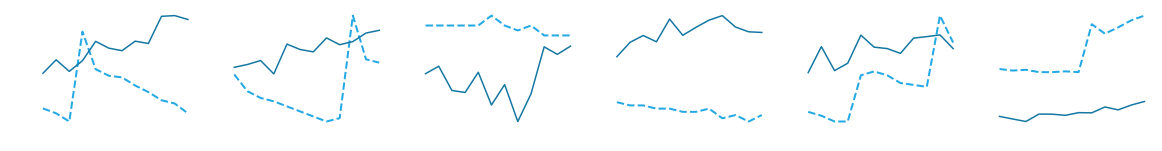

5-fold started.
Epoch:        0/   50000 cost: 7.624604, best: 100000.000
Training Acc: -49.408, Test Acc: -71.080
-123.318 -226.500 -3604.159 -253.609 -123.788 -33.068 
-727.406749803917
Epoch:      500/   50000 cost: 0.031302, best: 100000.000
Training Acc: 0.641, Test Acc: 0.499
-0.007 0.044 -0.406 0.706 -0.507 -0.190 
-0.0603266681163838
Epoch:     1000/   50000 cost: 0.018971, best: 100000.000
Training Acc: 0.326, Test Acc: -0.068
-0.525 -2.815 -36.060 0.689 -1.439 -0.534 
-6.780665809821239
Epoch:     1002/   50000 cost: 0.020204, best: 0.319 *Best value was replaced.
-0.525 -2.815 -36.060 0.689 -1.439 -0.534 
-6.780665809821239
Epoch:     1003/   50000 cost: 0.022301, best: 0.319 *Best value was replaced.
-0.525 -2.815 -36.060 0.689 -1.439 -0.534 
-6.780665809821239
Epoch:     1030/   50000 cost: 0.022614, best: 0.281 *Best value was replaced.
-0.525 -2.815 -36.060 0.689 -1.439 -0.534 
-6.780665809821239
Epoch:     1031/   50000 cost: 0.018977, best: 0.243 *Best value was replac

Epoch:     4500/   50000 cost: 0.010242, best: 0.028
Training Acc: 0.946, Test Acc: 0.866
0.545 0.421 0.450 0.675 0.786 0.896 
0.6289853374440314
Epoch:     4630/   50000 cost: 0.011861, best: 0.028 *Best value was replaced.
0.545 0.421 0.450 0.675 0.786 0.896 
0.6289853374440314
Epoch:     4660/   50000 cost: 0.010156, best: 0.027 *Best value was replaced.
0.545 0.421 0.450 0.675 0.786 0.896 
0.6289853374440314
Epoch:     4661/   50000 cost: 0.010195, best: 0.027 *Best value was replaced.
0.545 0.421 0.450 0.675 0.786 0.896 
0.6289853374440314
Epoch:     5000/   50000 cost: 0.009768, best: 0.027
Training Acc: 0.952, Test Acc: 0.896
0.620 0.594 -0.764 0.631 0.831 0.964 
0.47919247590752817
Epoch:     5048/   50000 cost: 0.008429, best: 0.027 *Best value was replaced.
0.620 0.594 -0.764 0.631 0.831 0.964 
0.47919247590752817
Epoch:     5049/   50000 cost: 0.009497, best: 0.026 *Best value was replaced.
0.620 0.594 -0.764 0.631 0.831 0.964 
0.47919247590752817
Epoch:     5056/   50000 co

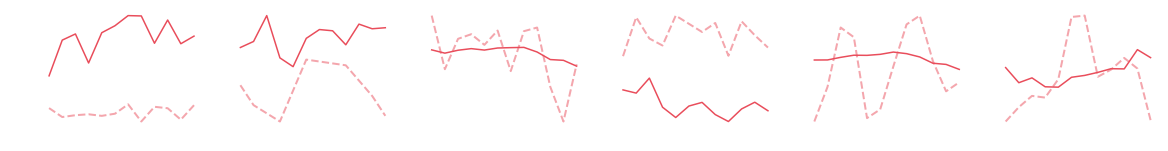

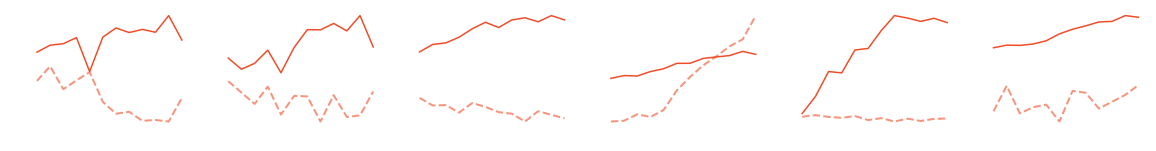

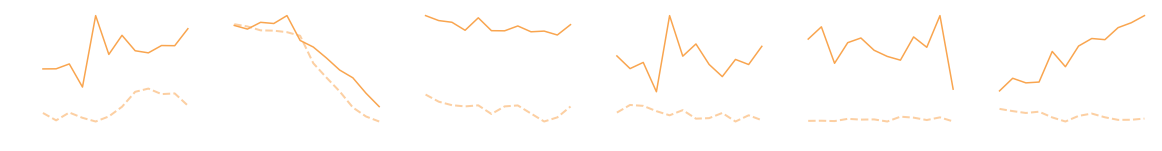

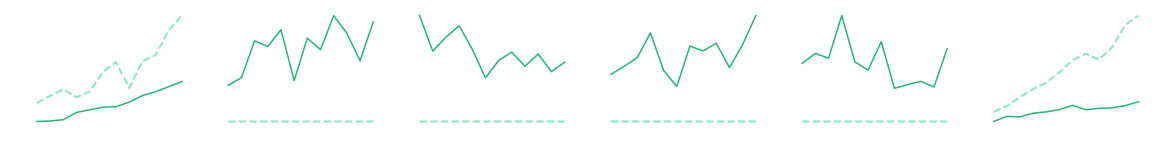

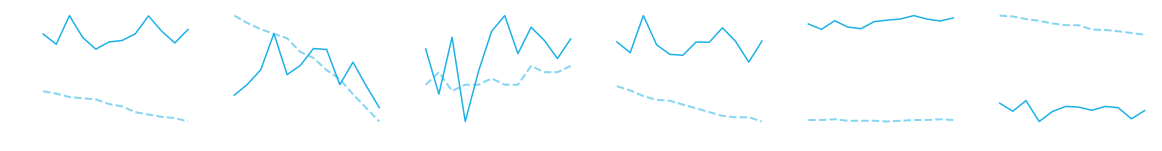

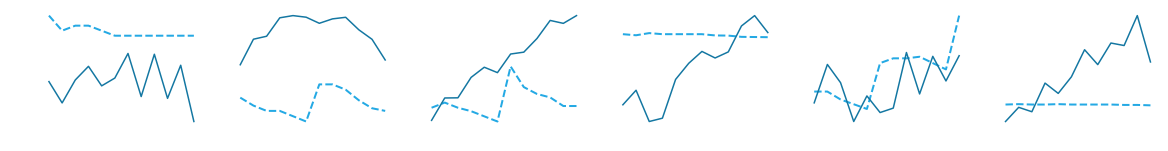

All fold vaildation were ended.
5-fold validation accuracy: 0.958


In [16]:
accuracies = []
for FOLD in range(N_FOLD):
    
    pred_input = pred_inputs[FOLD]
    pred_label = pred_labels[FOLD]
    
    rnn_input = rnn_inputs[FOLD]
    rnn_label = rnn_labels[FOLD]

    print("%d-fold started." % (FOLD+1))
    # Parameters
    EXPLANATION_F = EXPLANATION + "_F" + str(FOLD+1)
    LIMIT = 3002
    SHIELD = 1000
    
    global_step = tf.Variable(0, trainable=False)
    LEARNING_RATE = tf.train.exponential_decay(0.035, global_step, 3000, 0.96, staircase=True)
    EPSILON = 0.00001
    TRAINING_EPOCHS = 50000
    N_HIDDEN = 32
    N_FC_HIDDEN = 512
    DROP_PROB = 0.9
    BATCH_SIZE = 512
    DISPLAY_STEP = 500
    N_INPUT = pred_input.shape[2]
    N_OUTPUT = N_TASKS

    # tf Graph input
    x = tf.placeholder("float", [None, TIME_STEPS, N_INPUT])
    y = tf.placeholder("float", [None, OUTPUT_SIZE, N_OUTPUT])
    drop_prob = tf.placeholder("float")
    phase = tf.placeholder(tf.bool)
    
    # Define weights
    weights = tf.get_variable(EXPLANATION_F[-2:] + "wgt", shape=[N_HIDDEN, OUTPUT_SIZE], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(EXPLANATION_F[-2:] + "bias", shape=[OUTPUT_SIZE], initializer=tf.contrib.layers.xavier_initializer())
    variable_summaries(weights)
    variable_summaries(biases)    
    
    
    def RNN(x, weights, biases, drop_prob):

        x = tf.unstack(x, TIME_STEPS, 1)

        cell = rnn.LayerNormBasicLSTMCell(N_HIDDEN, dropout_keep_prob=drop_prob, reuse=tf.AUTO_REUSE)
        outputs, states = rnn.static_rnn(cell, x, dtype=tf.float32)
        
        activation = tf.matmul(outputs[-1], weights) + biases

        return activation

    def Task_specific_FC(x, n_hidden, phase, tasknum):
        h1 = BN_FC(x, n_hidden, phase, "task" + str(tasknum) + "_layer1")
        h2 = BN_FC(h1, n_hidden, phase, "task" + str(tasknum) + "_layer2")
        
        return FC(h2, OUTPUT_SIZE, "task" + str(tasknum) + "_out")
    
    # Construct model
    shared_layer = RNN(x, weights, biases, DROP_PROB)
    pred_1 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 1)
    pred_2 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 2)
    pred_3 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 3)
    pred_4 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 4)
    pred_5 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 5)
    pred_6 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 6)
    pred = tf.stack([pred_1, pred_2, pred_3, pred_4, pred_5, pred_6], axis=2)
    # Define loss and optimizer
    cost_1 = tf.losses.mean_squared_error(labels=y[:, :, 0], predictions=pred_1)
    cost_2 = tf.losses.mean_squared_error(labels=y[:, :, 1], predictions=pred_2)
    cost_3 = tf.losses.mean_squared_error(labels=y[:, :, 2], predictions=pred_3)
    cost_4 = tf.losses.mean_squared_error(labels=y[:, :, 3], predictions=pred_4)
    cost_5 = tf.losses.mean_squared_error(labels=y[:, :, 4], predictions=pred_5)
    cost_6 = tf.losses.mean_squared_error(labels=y[:, :, 5], predictions=pred_6)
    joint_cost = cost_1 + cost_2 + cost_3 + cost_4 + cost_5 + cost_6
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    optimizer_ = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    with tf.control_dependencies(update_ops):
        optimizer = optimizer_.minimize(joint_cost, global_step=global_step)
    tf.summary.scalar('cost', joint_cost)
    
    # Evaluate model
    total_error = tf.reduce_sum(tf.square(tf.subtract(tf.reshape(y, [-1, OUTPUT_SIZE*N_TASKS]), 
                                                      tf.reduce_mean(tf.reshape(y, [-1, OUTPUT_SIZE*N_TASKS])))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(tf.reshape(y, [-1, OUTPUT_SIZE*N_TASKS]),
                                                            tf.reshape(pred, [-1, OUTPUT_SIZE*N_TASKS]))))
    accuracy = tf.subtract(1., tf.divide(unexplained_error, total_error))
    tf.summary.scalar('accuracy', accuracy)
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged = tf.summary.merge_all()

    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    train_writer = tf.summary.FileWriter("./summary/train/" + "F"+ str(FOLD+1), sess.graph)
    test_writer = tf.summary.FileWriter("./summary/test/" + "F"+ str(FOLD+1))
    sess.run(init)

    # Launch the graph
    best_pred_acc = EX_PRED
    best_pred_cost = 100000
    ex_pred_acc = 0
    ex_pred_cost = 100000
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()

    for EPOCH in range(TRAINING_EPOCHS):

        batch_x, batch_y = resample(rnn_input, rnn_label, n_samples = BATCH_SIZE, replace = False)
        cost_, summary, _ = sess.run([joint_cost, merged, optimizer], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})
        train_writer.add_summary(summary, EPOCH)
        summary, pred_acc, pred_cost = sess.run([merged, accuracy, joint_cost],
                                                feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
        
        test_writer.add_summary(summary, EPOCH)
#         if pred_acc > ex_pred_acc:
#             if EPOCH <= SHIELD:
#                 pass
#             elif pred_acc > best_pred_acc:
#                 bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
#                 save_path = saver.save(sess, bestpath)
#                 best_pred_acc = pred_acc
#                 early_stop_buffer = 0
#         else:
#             early_stop_buffer += 1

            
#         if early_stop_buffer >= LIMIT:
#             if best_pred_acc < 0.75:
#                 continue
#             else:
#                 print ("\nEarly stopping.")
#                 break
        
#         ex_pred_acc = pred_acc
        if pred_cost < ex_pred_cost:
            if EPOCH <= SHIELD:
                pass
            elif pred_cost < best_pred_cost:
                bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_pred_cost = pred_cost
                early_stop_buffer = 0
                print ("Epoch: %8d/%8d cost: %.6f, best: %.3f *Best value was replaced." % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_cost))
                for i in range(N_TASKS):
                    print("%.3f"% r2_score(pred_label[:,:,i], R2[:,:,i]), end=" ")
                print("")
                print(r2_score(pred_label.reshape(-1, OUTPUT_SIZE*N_TASKS), R2.reshape(-1, OUTPUT_SIZE*N_TASKS)))
        else:
            early_stop_buffer += 1

            
        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break
        
        ex_pred_cost = pred_cost        
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH, TRAINING_EPOCHS, cost_, best_pred_cost))
            train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
            R2, pred_acc = sess.run([pred, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, pred_acc))
            for i in range(N_TASKS):
                print("%.3f"% r2_score(pred_label[:,:,i], R2[:,:,i]), end=" ")
            print("")
            print(r2_score(pred_label.reshape(-1, OUTPUT_SIZE*N_TASKS), R2.reshape(-1, OUTPUT_SIZE*N_TASKS)))


    print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_cost))
    train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
    pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,pred_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))
    
    
    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
    saver.restore(sess, bestpath)
    final_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    accuracies.append(final_acc)
    print ("Test accuracy:", final_acc)
    
    #Result visualizing
    prediction = sess.run(pred, feed_dict={x: pred_input, drop_prob: 1.0, phase: 0})
    print("Chronological graphs for fold # %d." % (FOLD+1))
    x_t = np.arange(0, OUTPUT_SIZE)

    prediction_csv = []
    pred_label_csv = []
    for _ in range(N_TASKS):
        
        NUMBERS = np.arange(1, prediction.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 661

        for NUMBER in NUMBERS:
            fig = plt.subplot(position)
            measured1 = plt.plot(x_t, pred_label[NUMBER, :, _], "--", linewidth=2, c=cmap_m[_])
            expect1 = plt.plot(x_t, prediction[NUMBER, :, _], c=cmap[_])
            fig.axis('off')

            position += 1
        plt.show()
        
        temp1 = (prediction[:, :, _] * (LABELMAXS[_] - LABELMINS[_])) + LABELMINS[_]
        temp2 = (pred_label[:, :, _] * (LABELMAXS[_] - LABELMINS[_])) + LABELMINS[_]
        prediction_csv.append(pd.DataFrame(temp1, index=pred_label_index[FOLD]))
        pred_label_csv.append(pd.DataFrame(temp2, index=pred_label_index[FOLD]))
    
    if not os.path.isdir("./results/"):
        os.makedirs("./results/")
    pd.concat(prediction_csv, axis=1).to_csv("./results/" + "output_" + EXPLANATION_F + ".CSV")
    pd.concat(pred_label_csv, axis=1).to_csv("./results/" + "labels_" + EXPLANATION_F + ".CSV")
    
    tf.reset_default_graph()
    sess.close()
    
print("All fold vaildation were ended.")
print("%d-fold validation accuracy: %.3f" % (N_FOLD, sum(accuracies)/N_FOLD))